# Convert VGG Face model to lasagne

In [1]:
import caffe

## Load caffe model

In [2]:
net_caffe = caffe.Net('VGG_FACE_deploy.prototxt', 'VGG_FACE.caffemodel', caffe.TEST)

In [3]:
import lasagne
import numpy as np
import matplotlib.pyplot as plt
import os
import theano
import theano.tensor as T
import cPickle as pickle
import gzip
%matplotlib inline

from lasagne.layers import InputLayer, DropoutLayer, FlattenLayer
from lasagne.layers import DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

Using gpu device 0: GRID K520 (CNMeM is disabled)
/home/ubuntu/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


## Define architecture in Lasagne

In [4]:
def vgg_face_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], num_filters=64, filter_size=3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], num_filters=64, filter_size=3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], pool_size=2, stride=2, mode='max', ignore_border=False)
    net['conv2_1'] = ConvLayer(net['pool1'], num_filters=128, filter_size=3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], num_filters=128, filter_size=3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], pool_size=2, stride=2, mode='max', ignore_border=False)
    net['conv3_1'] = ConvLayer(net['pool2'], num_filters=256, filter_size=3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], num_filters=256, filter_size=3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], num_filters=256, filter_size=3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], pool_size=2, stride=2, mode='max', ignore_border=False)
    net['conv4_1'] = ConvLayer(net['pool3'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], pool_size=2, stride=2, mode='max', ignore_border=False)
    net['conv5_1'] = ConvLayer(net['pool4'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], num_filters=512, filter_size=3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], pool_size=2, stride=2, mode='max', ignore_border=False)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['drop6'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['drop6'], num_units=4096)
    net['drop7'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(net['drop7'], nonlinearity=None, num_units=2622)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)
    return net

In [5]:
net = vgg_face_model()
layers_caffe = dict(zip(list(net_caffe._layer_names), net_caffe.layers))
keys = layers_caffe.keys()
for name, layer in net.items():
    try:
        if name in keys and len(layers_caffe[name].blobs) > 0 and len(layers_caffe[name].blobs[0].data.shape) == 2:
            layer.W.set_value(layers_caffe[name].blobs[0].data.T)
        else:
            layer.W.set_value(layers_caffe[name].blobs[0].data)
        layer.b.set_value(layers_caffe[name].blobs[1].data)     
    except AttributeError:
        continue

## Save model

In [6]:
values = lasagne.layers.get_all_param_values(net['prob'])
with gzip.open('vgg_face.pklz', 'wb') as f:
    pickle.dump(values, f, protocol=2)

## Load model

In [7]:
def load_model_values(filename):
    with gzip.open(filename, 'rb') as f:
        values = pickle.load(f)
        return values

### Define layers to be fine-tuned

In [10]:
finetune_layers = ['fc6','fc7','fc8']

for name, layer in net.iteritems():
    if name not in finetune_layers:
        if hasattr(layer, 'W'): layer.params[layer.W].discard('trainable')
        if hasattr(layer, 'b'): layer.params[layer.b].discard('trainable')

### Define Prediction function

In [44]:
# Theano symbolic variables
X_sym = T.tensor4()
y_sym = T.ivector()
prediction = T.argmax(lasagne.layers.get_output(net['prob'], X_sym))
pred = theano.function(inputs=[X_sym], outputs=prediction)
p_of_y = lasagne.layers.get_output(net['prob'], X_sym)
p_of_y_fn = theano.function(inputs=[X_sym], outputs=p_of_y)

### Prepare image

In [24]:
def prepare_image(path, ext='jpg'):
    im = plt.imread(path, ext)
    im = im.astype(theano.config.floatX)/255
    im = np.concatenate((np.zeros(shape=(218,23,3)),im), axis=1)
    im = np.concatenate((im,np.zeros(shape=(218,23,3))), axis=1)
    im = np.concatenate((np.zeros(shape=(3,224,3)),im), axis=0)
    im = np.concatenate((im,np.zeros(shape=(3,224,3))), axis=0)
    im = im.transpose(2,0,1)
    return im.astype(theano.config.floatX)

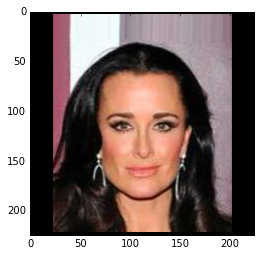

In [68]:
im = prepare_image('../../img_align_celeba/101299.jpg','jpg')
im = prepare_image('../../img_align_celeba/202598.jpg','jpg')
plt.imshow(im.transpose(1,2,0))

In [69]:
vgg_faces_classes = np.loadtxt('names.txt', dtype='str')

In [70]:
idx = pred(im.reshape(1,3,224,224))
vgg_faces_classes[idx]

'Kyle_Richards'

### Next Steps
* Study the loss function that we are going to use
* The dataset doesn't have names, it has face attributes. The NN has to predict 1 or -1 for each of the attributes